### flodym

In [1]:
import flodym as fd

In [2]:
dimension_definitions = [
    fd.DimensionDefinition(letter="s", name="substance", dtype=str),
]

In [3]:
parameter_definitions = [
    fd.ParameterDefinition(name="fibre_shares", dim_letters=("s",)),
    fd.ParameterDefinition(name="manure", dim_letters=("s",)),
]

In [4]:
process_names = [
    "sysenv",
    "dewatering",
    "soil application",
    "storage",
]

In [5]:
flow_definitions = [
    fd.FlowDefinition(from_process_name="sysenv", to_process_name="dewatering", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="storage", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="dewatering", to_process_name="soil application", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="storage", to_process_name="sysenv", dim_letters=("s",)),
    fd.FlowDefinition(from_process_name="soil application", to_process_name="sysenv", dim_letters=("s",)),
]

In [6]:
stock_definitions = [
    fd.StockDefinition(
        name="dummy",
        dim_letters=("s",),  # Only substance dimension
        subclass=fd.SimpleFlowDrivenStock,
        time_letter="s",
    ),
]

In [7]:
mfa_definition = fd.MFADefinition(
    dimensions=dimension_definitions,
    parameters=parameter_definitions,
    processes=process_names,
    flows=flow_definitions,
    stocks=stock_definitions,
)

In [8]:
dimension_files = {
    "substance": "data/dimension_substance.csv",
}

In [9]:
parameter_files = {
    "fibre_shares": "data/parameter_fibre_shares.csv",
    "manure": "data/parameter_manure.csv",
}

In [10]:
class ManureMFA(fd.MFASystem):
    def compute(self):

        self.flows["sysenv => dewatering"][...] = self.parameters["manure"]
        self.flows["dewatering => soil application"][...] = (
            self.flows["sysenv => dewatering"] * self.parameters["fibre_shares"]
        )  # Fibres
        self.flows["dewatering => storage"][...] = (
            self.flows["sysenv => dewatering"] * (
                1 - self.parameters["fibre_shares"]
            )
        )  # Liquid
        self.flows["soil application => sysenv"][...] = (
            self.flows["dewatering => soil application"]
        )  # Soil application outflow
        self.flows["storage => sysenv"][...] = (
            self.flows["dewatering => storage"]
        )  # Storage outflow

In [11]:
mfa_example = ManureMFA.from_csv(
    definition=mfa_definition,
    dimension_files=dimension_files,
    parameter_files=parameter_files,
)

In [12]:
mfa_example.compute()

In [13]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

mfa_example.check_mass_balance()

INFO:root:Checking mass balance of ManureMFA object...
INFO:root:Success - Mass balance is consistent!


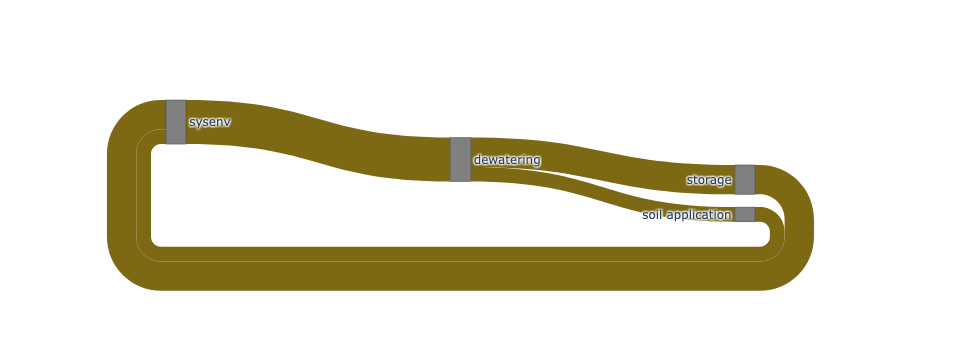

In [14]:
import flodym.export as fde

fig = fde.PlotlySankeyPlotter(mfa=mfa_example, exclude_processes=[], flow_color_dict = {"default":"rgb(125,105,19)"}).plot() 
fig.show()

### Brightway implementation

In [15]:
import bw2data as bd
import bw2io as bi

10:39:42+0100 [warning  ] Can't import `SimaProBlockCSVImporter` - please install `bw2io` with `pip install bw2io[multifunctional]` or install `multifunctional` and `bw_simapro_csv` manually.


#### setup project and databases

Setting up a new Brightway project "manure".

Note: The code currently depends on the "ecoinvent-3.11-cutoff-bw25" project from DdS 2025. We only use this project to have easy access to ecoinvent on the DdS server. To use the script after the Autumn School, modify the code to import ecoinvent with your own license or a copy of ecoinvent on your computer.

In [17]:
project_name = "manure"

if project_name in bd.projects:
    bd.projects.delete_project(name=project_name, delete_dir=True)

if "ecoinvent-3.11-cutoff-bw25" in bd.projects:
    bd.projects.set_current("ecoinvent-3.11-cutoff-bw25")
    bd.projects.copy_project("manure", switch=True)
    if "lci-pass_cars" in bd.databases:
        del bd.databases["lci-pass_cars"]  # Redundant db from ecoinvent-3.11-cutoff-bw25
else:
    print("The project 'ecoinvent-3.11-cutoff-bw25' is not found.")

print("active project:", bd.projects.current)

active project: manure


In [18]:
db_name = "manure"

if db_name in bd.databases:
    del bd.databases[db_name]    
db = bd.Database(db_name)
db.register()
bd.databases

Databases dictionary with 3 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	manure

#### manual LCA setup

In [19]:
def get_mfa_value(flow: str, substance: str):
    return mfa_example.flows[flow][substance].values.item()

In [20]:
ecoinvent_el = get_mfa_value('sysenv => dewatering', 'dry matter')
storage_dm = get_mfa_value('dewatering => storage', 'dry matter')

In [21]:
# nodes
manure_management = db.new_node(
    name='manure management',
    unit='ton',
    type=bd.labels.product_node_default,
)
manure_management.save()

manure_management_process = db.new_node(
    name='manure management process',
    location='DK',
    type=bd.labels.process_node_default,
)
manure_management_process.save()

electricity = db.new_node(
    name='electricity',
    unit='kWh',
    location='DK',
    type=bd.labels.product_node_default,
)
electricity.save()

dewatering_electricity = db.new_node(
    name='dewatering electricity',
    location='DK',
    type=bd.labels.process_node_default,
)
dewatering_electricity.save()

methane = db.new_node(
    name='methane',
    unit='kg',
    type=bd.labels.product_node_default,
)
methane.save()

storage_methane = db.new_node(
    name='storage methane',
    location='DK',
    type=bd.labels.process_node_default,
)
storage_methane.save()

In [22]:
bd.databases

Databases dictionary with 3 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	manure

In [23]:
#ei = bd.Database('ecoinvent-3.11-cutoff')
ei_electricity = bd.get_node(
    database='ecoinvent-3.11-cutoff',
    name='market for electricity, medium voltage',
    location='DK',
)

bs_methane = bd.get_node(
    database='ecoinvent-3.11-biosphere',
    name='Methane, non-fossil',
    categories=('air',)        
)

In [24]:
ei_electricity

'market for electricity, medium voltage' (kilowatt hour, DK, None)

In [25]:
manure_management_process.new_edge(
    amount=1,
    input=manure_management,
    type=bd.labels.production_edge_default,
).save()

manure_management_process.new_edge(
    amount=1,
    input=electricity,
    type=bd.labels.consumption_edge_default,
).save()

manure_management_process.new_edge(
    amount=1,
    input=methane,
    type=bd.labels.consumption_edge_default,
).save()

dewatering_electricity.new_edge(
    amount=1,
    input=electricity,
    type=bd.labels.production_edge_default
).save()

dewatering_electricity.new_edge(
    amount=1000,
    input=ei_electricity,
    type=bd.labels.consumption_edge_default,
).save()

storage_methane.new_edge(
    amount=1,
    input=methane,
    type=bd.labels.production_edge_default,
).save()

storage_methane.new_edge(
    amount=1,
    input=bs_methane,
    type=bd.labels.biosphere_edge_default,
).save()

In [26]:
my_method = bd.Method(
    ('ecoinvent-3.11', 
     'CML v4.8 2016', 
     'climate change', 
     'global warming potential (GWP100)')
)
my_method.name

('ecoinvent-3.11',
 'CML v4.8 2016',
 'climate change',
 'global warming potential (GWP100)')

#### simple LCIA

In [ ]:
import bw2calc as bc

functional_unit, data_objs, _ = bd.prepare_lca_inputs(
    demand={manure_management: 1},
    method=my_method.name,
)
    
my_lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
my_lca.lci()
my_lca.lcia()
my_lca.score

#### contribution analysis

In [329]:
# get all product nodes from our foreground system for contribution analysis
foreground_products = [node for node in db if node['type'] == bd.labels.product_node_default]
foreground_products

['methane' (kg, GLO, None),
 'manure management' (ton, GLO, None),
 'electricity' (kWh, DK, None)]

In [331]:
functional_unit, data_objs, _ = bd.prepare_lca_inputs(
    {manure_management: 1}, # amount is always 1 because we only scale edges to ecoinvent or biosphere databases
    method=('ecoinvent-3.11', 
     'CML v4.8 2016', 
     'climate change', 
     'global warming potential (GWP100)'),
)

my_lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
my_lca.lci()

product_scores = {}
# loop over all product nodes in the foreground system (eventually: also all LCIA methods)
for product in foreground_products:
    my_lca.lcia(demand={product.id: 1})
    product_scores[product['name']] = my_lca.score

INFO:bw2calc:Initialized LCA object. Demand: {247072925117497344: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7f0eb042d130>, <bw_processing.datapackage.Datapackage object at 0x7f0eb5ba9430>, <bw_processing.datapackage.Datapackage object at 0x7f0eb5ba9970>, <bw_processing.datapackage.Datapackage object at 0x7f0f1af579e0>]


In [332]:
product_scores

{'methane': 28.0,
 'manure management': 206.32850822059208,
 'electricity': 178.32850822059208}

#### automatic LCA setup

In [333]:
if "manure" in bd.databases:
    del bd.databases['manure']
db = bd.Database('manure')
db.register()

In [334]:
ei_steel = bd.get_node(
    name='market for steel, low-alloyed',
    location='GLO',
)
ei_steel['code']

'93c303c0802e644199a4cd6033095811'

In [306]:
list_of_things_in_mfa_with_impact = [
    {
        'name': 'storage methane',
        'unit': 'kg',
        'amount': get_mfa_value('dewatering => storage', 'dry matter'),
        'background_database_id': {
            'database': 'ecoinvent-3.11-biosphere',
            'name': 'Methane, non-fossil',
            'categories': ('air',),
            'code': 'da1157e2-7593-4dfd-80dd-a3449b37a4d8',
        }
    },
    {
        'name': 'dewatering electricity',
        'unit': 'kWh',
        'amount': get_mfa_value('sysenv => dewatering', 'dry matter'),
        'background_database_id': {
            'database': 'ecoinvent-3.11-cutoff',
            'name': 'market for electricity, medium voltage',
            'code': '6bcbd7fc891c8b3bf0dd96027c1f9b0e',
        }
    },
    {
        'name': 'steel',
        'unit': 'kg',
        'amount': get_mfa_value('sysenv => dewatering', 'dry matter') * 20,
        'background_database_id': {
            'database': 'ecoinvent-3.11-cutoff',
            'name': 'market for steel, low-alloyed',
            'code': '93c303c0802e644199a4cd6033095811',
        }
    },
]

In [307]:
# def fill_database_from_list_of_things_with_impact(db, list_of_things_in_mfa_with_impact):
functional_unit_process = db.new_node(
    name='functional_unit_process',
    code='functional_unit_process',
    type=bd.labels.process_node_default,
)
functional_unit_process.save()

functional_unit_product = db.new_node(
    name='functional_unit',
    code='functional_unit',
    unit='kg',
    type=bd.labels.product_node_default,
)
functional_unit_product.save()

functional_unit_edge = functional_unit_process.new_edge(
        amount=1,
        input=functional_unit_product,
        type=bd.labels.production_edge_default,    
)
functional_unit_edge.save()  

for thing in list_of_things_in_mfa_with_impact:
    product = db.new_node(
        name=thing['name'],
        code=thing['name'],
        type=bd.labels.product_node_default,
    )
    product.save()
    
    process = db.new_node(
        name=f'{thing['name']}_process',
        code=f'{thing['name']}_process',
        unit=thing['unit'],
        type=bd.labels.process_node_default,
    )
    process.save()

    edge = process.new_edge(
        amount=1,
        input=product,
        type=bd.labels.production_edge_default,
    )
    edge.save()

    edge = functional_unit_process.new_edge(
        amount=1,
        input=product,
        type=bd.labels.consumption_edge_default,
    )
    edge.save()

    if thing['background_database_id']['database'] == 'ecoinvent-3.11-biosphere':
        biosphere_flow = bd.get_node(
            database='ecoinvent-3.11-biosphere',
            code=thing['background_database_id']['code'],
        )
       
        edge = process.new_edge(
            database='ecoinvent-3.11-biosphere',
            name=thing['background_database_id']['name'],
            categories=thing['background_database_id']['categories'],
            amount=thing['amount'],
            input=biosphere_flow,
            type=bd.labels.biosphere_edge_default,
        )
        edge.save()
        
    elif thing['background_database_id']['database'] == 'ecoinvent-3.11-cutoff':
        ecoinvent_product = bd.get_node(
            database='ecoinvent-3.11-cutoff',
            code=thing['background_database_id']['code'],
        )
       
        edge = process.new_edge(
            database='ecoinvent-3.11-biosphere',
            name=thing['background_database_id']['name'],
            amount=thing['amount'],
            input=ecoinvent_product,
            type=bd.labels.consumption_edge_default,
        )
        edge.save()
    else:
        print('Ecoinvent database not found. Check database name.')
        

In [308]:
import bw2calc as bc

functional_unit, data_objs, _ = bd.prepare_lca_inputs(
    {functional_unit_product: 1},
    method=(
        'ecoinvent-3.11', 
        'CML v4.8 2016', 
        'climate change', 
        'global warming potential (GWP100)'),
)

my_lca = bc.LCA(demand=functional_unit, data_objs=data_objs)
my_lca.lci()
my_lca.lcia()
my_lca.score

INFO:bw2calc:Initialized LCA object. Demand: {247068269658161152: 1}, data_objs: [<bw_processing.datapackage.Datapackage object at 0x7f0eaea01100>, <bw_processing.datapackage.Datapackage object at 0x7f0eaea03920>, <bw_processing.datapackage.Datapackage object at 0x7f0eaea00c20>, <bw_processing.datapackage.Datapackage object at 0x7f0f1aff4740>]


5.195549749830661